# Basic Usage of Dynamic HMC in IMP

## Introduction

Like most implementations of dynamic/adaptive Hamiltonian Monte Carlo (HMC),
IMP's is designed to be run for a warm-up period in which the step size and
metric are adapted in an automated fashion, followed by a sampling period.
Consequently, for most applications, the user will only need one function:
`IMP.hmc.defaults.setup_warmup_run_hmc`. For all of the options, consult the
source code. This notebook demonstrates how one would apply the HMC sampler on
several trivial sampling problems, analyze the output with
[ArviZ](https://arviz-devs.github.io/arviz), and compare with the usual Random
Walk Monte Carlo (RWMC) approach with Gibbs samplers typically used in IMP.

## Set-up and Imports

In [1]:
import numpy as np

import IMP
import IMP.core
import IMP.isd
import IMP.hmc
from IMP.hmc.defaults import setup_warmup_run_hmc
from IMP.hmc.diagnostics import get_inference_data
from IMP.hmc.julia import set_julia_seed

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import arviz as az  # arviz *must* be imported after IMP.hmc (for now)

az.style.use(["default", "arviz-colors"])

# Set random seeds
IMP.random_number_generator.seed(1608637542)
set_julia_seed(3421126067)
np.random.seed(4083286876)

/usr/local/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
def setup_nvariate_normal(
    m, N=1, mu=0.0, sigma=1.0, lb=-np.inf, ub=np.inf, make_movers=False
):
    rs = []
    ps = []

    try:
        list(mu)
    except TypeError:
        mu = [mu] * N

    try:
        list(sigma)
    except TypeError:
        sigma = [sigma] * N

    movers = []

    for n in range(N):
        p = IMP.isd.Nuisance.setup_particle(IMP.Particle(m))
        p.set_nuisance_is_optimized(True)
        p.set_lower(lb)
        p.set_upper(ub)
        p.set_name("x{}".format(n))
        ps.append(p)

        r = IMP.isd.GaussianRestraint(p.get_particle(), mu[n], sigma[n])
        rs.append(r)

        if make_movers:
            mvr = IMP.core.NormalMover(
                m, p.get_particle_index(), [p.get_nuisance_key()], 1.0
            )
            movers.append(mvr)

    rs = IMP.RestraintSet(rs, 1.0)
    sf = IMP.core.RestraintsScoringFunction(rs)

    if make_movers:
        return ps, sf, movers

    return ps, sf


ess_cols = ["ess_mean", "ess_sd", "ess_bulk", "ess_tail"]

## $N$-variate Normal

### 1D normal

#### HMC

In [3]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=1, make_movers=True)
for p in ps:
    p.set_nuisance(np.random.normal())
hmc = setup_warmup_run_hmc(sf, metric="unit", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("n_leapfrog").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 5.83s (0.00232s/eval)
9 divergent transitions were encountered during warm-up (0.900%%)
Mean warm-up statistics:
    stepsize: 1.39
    n_leapfrog: 2.51
    accept_stat: 0.791
    lp: -1.44
    energy: 1.94
    treedepth: 1.39
    diverging: 0.009
Sampling from HMC for 2000 steps.
Mean HMC statistics:
    stepsize: 0.637
    n_leapfrog: 3.75
    accept_stat: 0.972
    lp: -1.42
    energy: 1.9
    treedepth: 1.79
    diverging: 0
7506 scoring evaluations computed during sampling


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,-0.015,1.004,-1.944,1.766,0.046,0.039,477.0,340.0,491.0,375.0,NaN


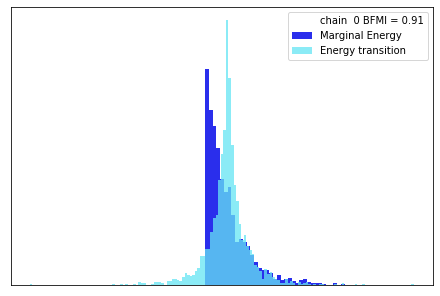

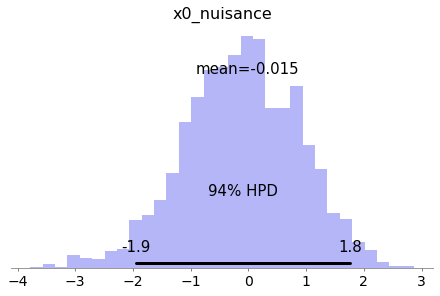

In [4]:
az.plot_energy(hmc_dataset, kind="hist")
az.plot_posterior(hmc_dataset, kind="hist")

#### RWMC

In [5]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(5)
for p in ps:
    p.set_nuisance(np.random.normal())

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1782), minimum_shape: (chains=2, draws=4)


Acceptance rate: 0.237


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.019,1.098,-1.942,2.051,0.028,0.022,1543.0,1211.0,1547.0,1434.0,NaN


In [6]:
ess_ratios = hmc_summary[ess_cols] / rwmc_summary[ess_cols]
ess_ratios.columns = [c + "_ratio" for c in ess_cols]
ess_ratios

,ess_mean_ratio,ess_sd_ratio,ess_bulk_ratio,ess_tail_ratio
x0_nuisance,0.309138,0.28076,0.317388,0.261506


### 10D Normal

#### HMC

In [7]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=10, make_movers=True)
for p in ps:
    p.set_nuisance(np.random.normal())
hmc = setup_warmup_run_hmc(sf, metric="diag", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("n_leapfrog").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 7.3s (0.000481s/eval)
7 divergent transitions were encountered during warm-up (0.700%%)
Mean warm-up statistics:
    stepsize: 0.869
    n_leapfrog: 15.2
    accept_stat: 0.791
    lp: -14.2
    energy: 19.4
    treedepth: 2.75
    diverging: 0.007
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

Mean HMC statistics:
    stepsize: 1.08
    n_leapfrog: 3
    accept_stat: 0.696
    lp: -14.1
    energy: 19.1
    treedepth: 2
    diverging: 0
5998 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,-0.014,0.951,-1.698,1.844,0.016,0.020,3511.0,1098.0,3547.0,1516.0,NaN
x1_nuisance,0.024,0.959,-1.661,1.890,0.016,0.021,3621.0,1044.0,3604.0,1572.0,NaN
x2_nuisance,-0.024,0.991,-1.791,1.894,0.017,0.024,3467.0,875.0,3441.0,1606.0,NaN
x3_nuisance,-0.005,1.047,-2.072,1.837,0.016,0.024,4495.0,919.0,4478.0,1491.0,NaN
x4_nuisance,0.002,1.008,-1.953,1.765,0.016,0.023,3827.0,984.0,3835.0,1591.0,NaN
x5_nuisance,-0.001,0.995,-1.807,1.800,0.016,0.023,3924.0,926.0,3874.0,1527.0,NaN
x6_nuisance,-0.001,0.990,-1.702,1.985,0.015,0.023,4482.0,921.0,4463.0,1527.0,NaN
x7_nuisance,-0.016,1.030,-1.959,1.902,0.016,0.030,4247.0,581.0,4249.0,1304.0,NaN
x8_nuisance,0.003,1.017,-1.900,1.842,0.017,0.024,3557.0,882.0,3594.0,1282.0,NaN
x9_nuisance,0.034,0.965,-1.740,1.852,0.017,0.023,3415.0,873.0,3408.0,1470.0,NaN


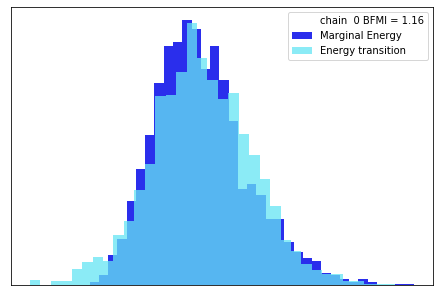

In [8]:
az.plot_energy(hmc_dataset, kind="hist")

#### RWMC

In [9]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(0.78)
for p in ps:
    p.set_nuisance(np.random.normal())

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 150), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 150), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 150), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 150), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 150), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 150), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 150), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 150), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape valida

Acceptance rate: 0.249


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.260,0.984,-1.392,2.190,0.191,0.136,27.0,27.0,27.0,51.0,NaN
x1_nuisance,-0.293,0.858,-1.863,1.171,0.156,0.111,30.0,30.0,31.0,35.0,NaN
x2_nuisance,-0.207,0.934,-1.758,1.503,0.232,0.167,16.0,16.0,16.0,28.0,NaN
x3_nuisance,-0.057,1.026,-1.719,1.666,0.200,0.143,26.0,26.0,26.0,61.0,NaN
x4_nuisance,0.221,1.104,-2.125,2.090,0.329,0.239,11.0,11.0,12.0,20.0,NaN
x5_nuisance,0.048,0.822,-1.621,1.363,0.187,0.134,19.0,19.0,19.0,67.0,NaN
x6_nuisance,-0.430,0.886,-1.798,1.539,0.175,0.125,26.0,26.0,26.0,65.0,NaN
x7_nuisance,0.019,0.981,-1.913,1.522,0.217,0.156,20.0,20.0,27.0,25.0,NaN
x8_nuisance,0.052,1.154,-2.097,2.400,0.253,0.181,21.0,21.0,23.0,42.0,NaN
x9_nuisance,-0.125,0.900,-1.858,1.363,0.202,0.145,20.0,20.0,20.0,62.0,NaN


In [10]:
ess_ratios = hmc_summary[ess_cols] / rwmc_summary[ess_cols]
ess_ratios.columns = [c + "_ratio" for c in ess_cols]
ess_ratios

,ess_mean_ratio,ess_sd_ratio,ess_bulk_ratio,ess_tail_ratio
x0_nuisance,130.037037,40.666667,131.370370,29.725490
x1_nuisance,120.700000,34.800000,116.258065,44.914286
x2_nuisance,216.687500,54.687500,215.062500,57.357143
x3_nuisance,172.884615,35.346154,172.230769,24.442623
x4_nuisance,347.909091,89.454545,319.583333,79.550000
x5_nuisance,206.526316,48.736842,203.894737,22.791045
x6_nuisance,172.384615,35.423077,171.653846,23.492308
x7_nuisance,212.350000,29.050000,157.370370,52.160000
x8_nuisance,169.380952,42.000000,156.260870,30.523810
x9_nuisance,170.750000,43.650000,170.400000,23.709677


### 100D Gaussian

#### HMC

In [11]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=100, make_movers=True)
for p in ps:
    p.set_nuisance(np.random.normal())
hmc = setup_warmup_run_hmc(sf, metric="diag", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("n_leapfrog").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 16.7s (0.00046s/eval)
5 divergent transitions were encountered during warm-up (0.500%%)
Mean warm-up statistics:
    stepsize: 0.543
    n_leapfrog: 36.3
    accept_stat: 0.791
    lp: -142
    energy: 192
    treedepth: 3.6
    diverging: 0.005
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    stepsize: 0.544
    n_leapfrog: 7
    accept_stat: 0.792
    lp: -142
    energy: 192
    treedepth: 3
    diverging: 0
14000 scoring evaluations computed during sampling


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.018,1.070,-1.852,2.088,0.017,0.029,3750.0,688.0,3747.0,1403.0,NaN
x1_nuisance,-0.020,1.026,-2.026,1.774,0.017,0.026,3696.0,788.0,3721.0,1244.0,NaN
x2_nuisance,-0.003,0.983,-1.775,1.829,0.017,0.026,3441.0,691.0,3445.0,1424.0,NaN
x3_nuisance,0.010,1.002,-2.021,1.785,0.016,0.027,3756.0,701.0,3772.0,1272.0,NaN
x4_nuisance,0.024,1.001,-1.782,1.844,0.018,0.028,3253.0,643.0,3237.0,1076.0,NaN
x5_nuisance,-0.018,0.960,-1.892,1.811,0.017,0.025,3173.0,740.0,3175.0,1431.0,NaN
x6_nuisance,-0.001,0.982,-1.932,1.747,0.014,0.024,4800.0,819.0,4857.0,1374.0,NaN
x7_nuisance,0.017,0.969,-1.782,1.801,0.016,0.023,3814.0,866.0,3790.0,1526.0,NaN
x8_nuisance,0.018,0.984,-1.942,1.747,0.016,0.024,3604.0,814.0,3605.0,1592.0,NaN
x9_nuisance,0.006,1.025,-1.828,1.919,0.016,0.028,4106.0,686.0,4152.0,1148.0,NaN


#### RWMC

In [12]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(0.23)
for p in ps:
    p.set_nuisance(np.random.normal())

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation fai

Acceptance rate: 0.357


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 51), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation fai

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,-0.333,0.640,-1.472,0.681,0.351,0.289,3.0,3.0,5.0,14.0,NaN
x1_nuisance,-0.559,0.308,-1.095,-0.027,0.092,0.088,11.0,7.0,11.0,33.0,NaN
x2_nuisance,-0.644,0.552,-1.548,0.303,0.203,0.150,7.0,7.0,8.0,14.0,NaN
x3_nuisance,0.488,0.268,0.140,1.025,0.134,0.117,4.0,3.0,4.0,32.0,NaN
x4_nuisance,-0.500,0.765,-1.492,0.869,0.274,0.202,8.0,8.0,8.0,12.0,NaN
x5_nuisance,1.237,0.563,0.365,2.086,0.397,0.336,2.0,2.0,2.0,18.0,NaN
x6_nuisance,-0.070,0.406,-0.667,0.573,0.267,0.220,2.0,2.0,2.0,14.0,NaN
x7_nuisance,0.899,0.337,0.300,1.504,0.125,0.102,7.0,6.0,7.0,30.0,NaN
x8_nuisance,0.249,0.367,-0.246,0.955,0.248,0.206,2.0,2.0,2.0,30.0,NaN
x9_nuisance,-0.952,0.705,-1.816,0.284,0.296,0.221,6.0,6.0,6.0,14.0,NaN


In [13]:
ess_ratios = hmc_summary[ess_cols] / rwmc_summary[ess_cols]
ess_ratios.columns = [c + "_ratio" for c in ess_cols]
ess_ratios

,ess_mean_ratio,ess_sd_ratio,ess_bulk_ratio,ess_tail_ratio
x0_nuisance,1250.000000,229.333333,749.400000,100.214286
x1_nuisance,336.000000,112.571429,338.272727,37.696970
x2_nuisance,491.571429,98.714286,430.625000,101.714286
x3_nuisance,939.000000,233.666667,943.000000,39.750000
x4_nuisance,406.625000,80.375000,404.625000,89.666667
x5_nuisance,1586.500000,370.000000,1587.500000,79.500000
x6_nuisance,2400.000000,409.500000,2428.500000,98.142857
x7_nuisance,544.857143,144.333333,541.428571,50.866667
x8_nuisance,1802.000000,407.000000,1802.500000,53.066667
x9_nuisance,684.333333,114.333333,692.000000,82.000000


## Constrained variables

### $x \sim \operatorname{Half-Normal}(0, 1)$

#### HMC

In [14]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=1, lb=0, make_movers=True)
for p in ps:
    p.set_nuisance(np.exp(np.random.normal()))
hmc = setup_warmup_run_hmc(sf, metric="unit", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("n_leapfrog").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 6.06s (0.00173s/eval)
44 divergent transitions were encountered during warm-up (4.400%%)
Mean warm-up statistics:
    stepsize: 0.843
    n_leapfrog: 3.5
    accept_stat: 0.792
    lp: -1.92
    energy: 2.42
    treedepth: 1.6
    diverging: 0.044
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    stepsize: 1.78
    n_leapfrog: 1.49
    accept_stat: 0.474
    lp: -2.04
    energy: 2.55
    treedepth: 0.968
    diverging: 0.214
2983 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.737,0.532,0.009,1.701,0.023,0.018,529.0,440.0,527.0,299.0,NaN


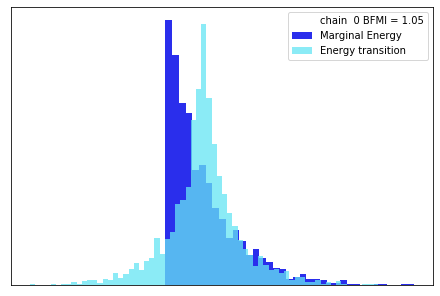

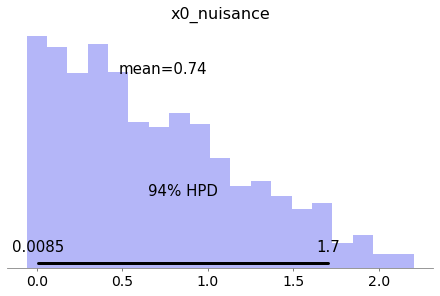

In [15]:
az.plot_energy(hmc_dataset, kind="hist")
az.plot_posterior(hmc_dataset, kind="hist")

#### RWMC

In [16]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(2)
for p in ps:
    p.set_nuisance(np.exp(np.random.normal()))

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2056), minimum_shape: (chains=2, draws=4)


Acceptance rate: 0.689


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.31,0.556,0.0,1.453,0.017,0.012,1067.0,1067.0,1077.0,1221.0,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x16394ec90>],
      dtype=object)

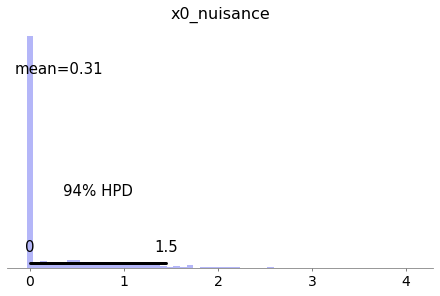

In [17]:
az.plot_posterior(rwmc_dataset, kind="hist")

In this example, we can see how IMP's constraint handling creates an invalid
Markov transition when the posterior is defined at the constraint value. Any
proposal that falls outside of the constraint is thresholded to the nearest
bound. If the scoring function is defined at that bound then the entirety of
the transition distributions mass outside the bound is placed at the bound,
and it will be accepted at a higher rate than it ought to be.

### $x \sim \operatorname{Truncated-Normal}(0, 1)$, $-1 < x < 1$

#### HMC

In [18]:
m = IMP.Model()
ps, sf, movers = setup_nvariate_normal(m, N=1, lb=-2, ub=2, make_movers=True)
for p in ps:
    p.set_nuisance(np.tanh(np.random.normal() / 2))
hmc = setup_warmup_run_hmc(sf, metric="diag", nadapt=1000, nsample=2000)
nsteps = hmc.stats.get_samples("n_leapfrog").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc)
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 4.61s (0.00178s/eval)
3 divergent transitions were encountered during warm-up (0.300%%)
Mean warm-up statistics:
    stepsize: 1.45
    n_leapfrog: 2.59
    accept_stat: 0.792
    lp: -1.52
    energy: 2
    treedepth: 1.44
    diverging: 0.003
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    stepsize: 2.83
    n_leapfrog: 2.5
    accept_stat: 0.148
    lp: -1.53
    energy: 2.05
    treedepth: 1.36
    diverging: 0
5008 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,0.013,0.836,-1.439,1.605,0.042,0.041,387.0,205.0,406.0,426.0,NaN


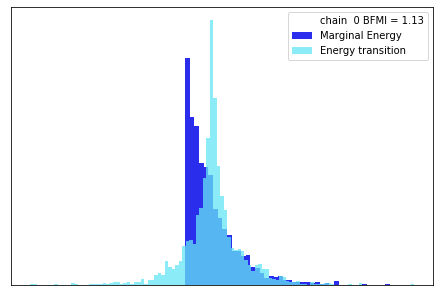

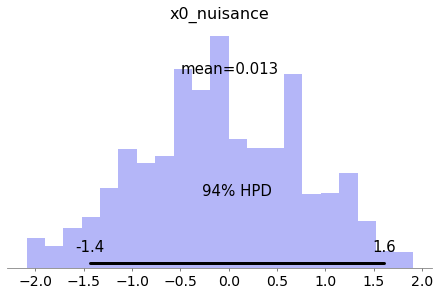

In [19]:
az.plot_energy(hmc_dataset, kind="hist")
az.plot_posterior(hmc_dataset, kind="hist")

#### RWMC

In [20]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers(movers)
for mover in movers:
    mover.set_sigma(2)
for p in ps:
    p.set_nuisance(np.tanh(np.random.normal() / 2))

mc.optimize(int(nsteps * 0.5 / len(movers)))
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(int(nsteps / len(movers)))
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip(hmc.opt_vars.get_names(), map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3061), minimum_shape: (chains=2, draws=4)


Acceptance rate: 0.611


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x0_nuisance,-0.013,1.256,-2.0,2.0,0.042,0.03,879.0,879.0,856.0,1130.0,NaN


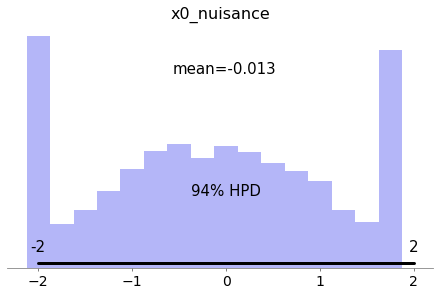

In [21]:
az.plot_posterior(rwmc_dataset, kind="hist")

### $x \sim \operatorname{vMF}(50)$, $x \in S^2$

Here $x$ is a 3D unit vector, an element of the 2-sphere, distributed
according to the von Mises-Fisher distribution with concentration of 50.

#### Restraint and Setup

In [22]:
class vonMisesFisherRestraint(IMP.Restraint):
    def __init__(self, x, mu, kappa):
        self.x = IMP.core.Direction(x)
        super().__init__(self.x.get_model(), "vonMisesFisherRestraint%1%")
        self.kappa = kappa
        self.mu = mu
        self.km = kappa * np.array(mu, dtype=np.double)

    def do_add_score_and_derivatives(self, sa):
        score = -self.km.dot(self.x.get_direction())
        if sa.get_derivative_accumulator():
            self.x.add_to_direction_derivatives(
                -self.km, sa.get_derivative_accumulator()
            )
        sa.add_score(score)

    def do_get_inputs(self):
        return [self.x.get_particle()]


def setup_S2_vMF(m, mu=np.array([0.0, 0.0, 1.0]), kappa=10.0, make_mover=False):
    rs = []

    p = IMP.core.Direction.setup_particle(
        IMP.Particle(m), IMP.algebra.get_random_vector_on_unit_sphere()
    )
    p.set_direction_is_optimized(True)
    p.set_name("x")

    r = vonMisesFisherRestraint(p, mu, kappa)
    rs.append(r)

    rs = IMP.RestraintSet(rs, 1.0)
    sf = IMP.core.RestraintsScoringFunction(rs)

    if make_mover:
        mvr = IMP.core.DirectionMover(p, 1.0, 0.0)
        return p, sf, mvr

    return p, sf

#### HMC

In [23]:
m = IMP.Model()
p, sf, mover = setup_S2_vMF(m, kappa=50, make_mover=True)
p.set_direction(IMP.algebra.get_random_vector_on_unit_sphere())

hmc = setup_warmup_run_hmc(
    sf, metric="diag", adapt_delta=0.9, nadapt=1000, nsample=2000
)
nsteps = hmc.stats.get_samples("n_leapfrog").sum()
print("{0} scoring evaluations computed during sampling".format(nsteps))

hmc_dataset = get_inference_data(hmc, varnames=["x", "y", "z"])
hmc_summary = az.summary(hmc_dataset)
hmc_summary

Initializing step size
Warming up HMC for 1000 steps.
Finished warmup after 8.11s (0.000775s/eval)
11 divergent transitions were encountered during warm-up (1.100%%)
Mean warm-up statistics:
    stepsize: 0.372
    n_leapfrog: 10.5
    accept_stat: 0.891
    lp: 47.5
    energy: -46
    treedepth: 2.91
    diverging: 0.011
Sampling from HMC for 2000 steps.


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


Mean HMC statistics:
    stepsize: 0.625
    n_leapfrog: 5.37
    accept_stat: 0.731
    lp: 47.5
    energy: -46
    treedepth: 2.25
    diverging: 0.023
10744 scoring evaluations computed during sampling


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.004,0.139,-0.254,0.268,0.004,0.003,1411.0,901.0,1406.0,1347.0,NaN
y,0.002,0.139,-0.269,0.247,0.004,0.003,1464.0,1019.0,1471.0,1379.0,NaN
z,0.980,0.021,0.941,1.000,0.001,0.000,892.0,890.0,862.0,1054.0,NaN


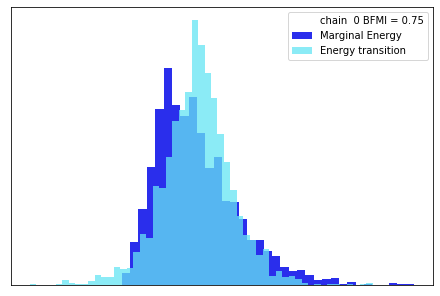

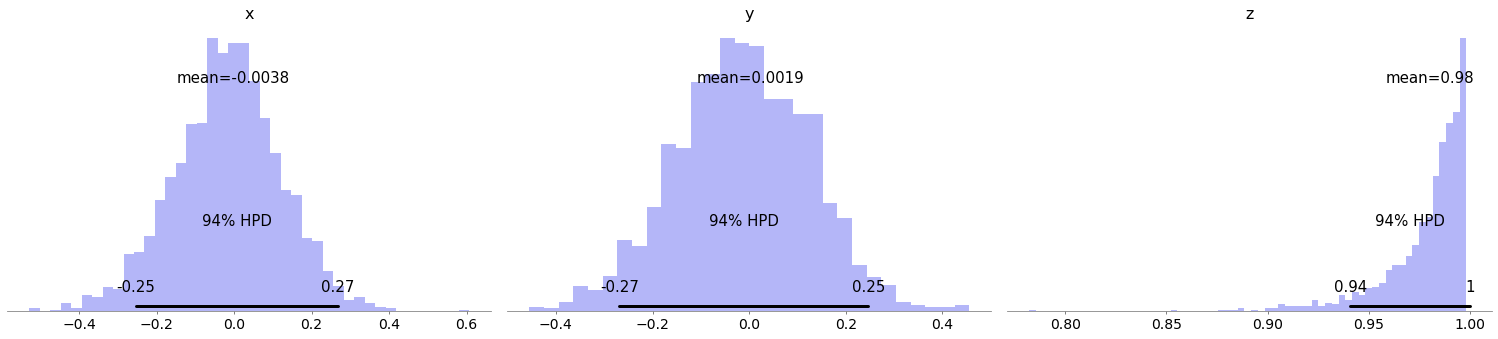

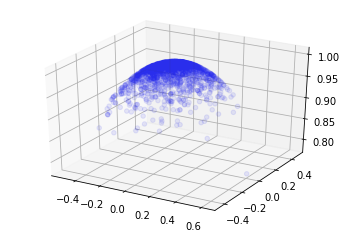

In [24]:
az.plot_energy(hmc_dataset, kind="hist")
az.plot_posterior(hmc_dataset, kind="hist")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    hmc_dataset.posterior.x, hmc_dataset.posterior.y, hmc_dataset.posterior.z, alpha=0.1
)
plt.show()

#### RWMC

In [25]:
mc = IMP.core.MonteCarlo(m)
mc.set_return_best(False)
mc.set_scoring_function(sf)
mc.add_movers([mover])
mover.set_maximum_rotation(0.9)
p.set_direction(IMP.algebra.get_random_vector_on_unit_sphere())

mc.optimize(nsteps)
mc.reset_statistics()
os = IMP.hmc.SaveAttributesOptimizerState(hmc.interface)
mc.add_optimizer_state(os)
mc.optimize(nsteps)
print(
    "Acceptance rate: {0:.3g}".format(
        mc.get_number_of_accepted_steps() / mc.get_number_of_proposed_steps()
    )
)
rwmc_dataset = az.from_dict(
    posterior=dict(zip("xyz", map(np.array, zip(*os.get_values()))))
)
rwmc_summary = az.summary(rwmc_dataset)
rwmc_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2743), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2743), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2743), minimum_shape: (chains=2, draws=4)


Acceptance rate: 0.255


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.003,0.150,-0.278,0.277,0.004,0.003,1164.0,1085.0,1162.0,1442.0,NaN
y,0.004,0.148,-0.267,0.271,0.005,0.003,1027.0,1027.0,1034.0,1159.0,NaN
z,0.977,0.021,0.938,1.000,0.001,0.001,776.0,775.0,853.0,1086.0,NaN


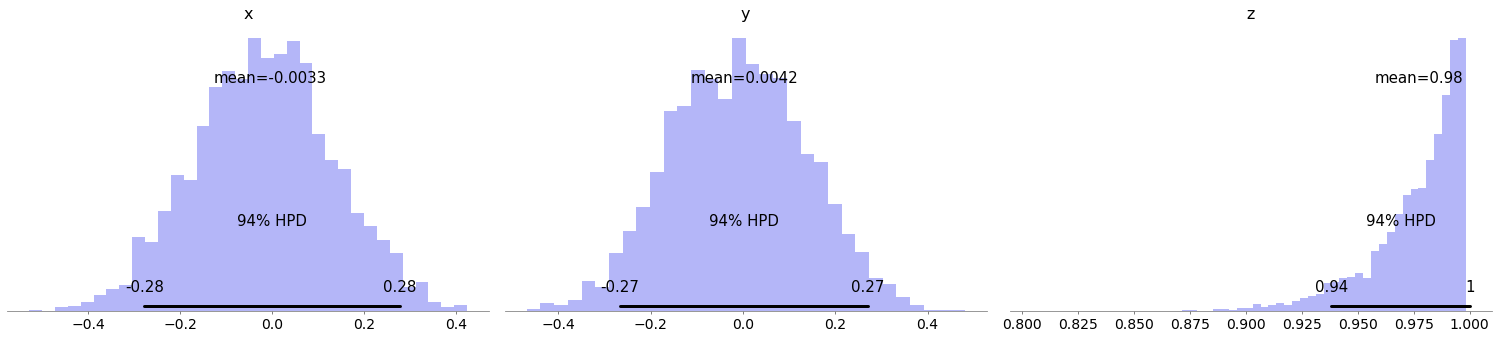

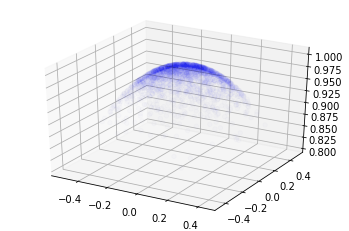

In [26]:
az.plot_posterior(rwmc_dataset, kind="hist")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    rwmc_dataset.posterior.x,
    rwmc_dataset.posterior.y,
    rwmc_dataset.posterior.z,
    alpha=0.01,
)
plt.show()

In [27]:
ess_ratios = hmc_summary[ess_cols] / rwmc_summary[ess_cols]
ess_ratios.columns = [c + "_ratio" for c in ess_cols]
ess_ratios

,ess_mean_ratio,ess_sd_ratio,ess_bulk_ratio,ess_tail_ratio
x,1.212199,0.830415,1.209983,0.934119
y,1.425511,0.992210,1.422631,1.189819
z,1.149485,1.148387,1.010551,0.970534
